In [1]:
import itertools
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

import json
import functools
from glob import glob
import os

from importlib import reload

import utils
import persim

import tifffile as tf
from KDEpy import FFTKDE
from scipy import ndimage,stats,spatial
from sklearn import decomposition, preprocessing, tree, metrics

In [2]:
nuclei_mask_cutoff = 1
seed = 42
ndims = 3
fs = 12
PP = 6
dpi = 96
minlife = 0.0
rng = np.random.default_rng(seed)
permmethod = stats.PermutationMethod(n_resamples=999, random_state=rng)

Cmap='plasma'
pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
s = 50
alphaNmin = 0.1
alphaNmax = 10

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#f0e442', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#e0e0e0', '#000000']
cmap = ['Blues_r', 'RdPu_r', 'Greens_r', 'BuPu_r', 'Oranges_r', 'Wistia', 'YlOrBr_r', 'gray', 'gist_gray']
box_params = {'widths':0.75, 'patch_artist':True, 'medianprops':{'lw':3, 'color':'red'} }
#figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'
sample = 'D2'

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/' + sample + os.sep
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep + sample + os.sep
geosrc =  '..' + os.sep + 'geometry' + os.sep + sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
metaecc['eccentricity'] = metaecc['eccentricity'].max() - metaecc['eccentricity'].values

metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')
cell_nuc.loc[cell_nuc['n_bot'] == 1, 'n_bot'] = 0
cell_nuc.loc[cell_nuc['n_top'] == 61, 'n_top'] = 65

transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
Cs = dict(zip(Genes, ['#56b4e9','#cc79a7']))
Ms = dict(zip(Genes, ['D','s']))
Ps = dict(zip(Genes, ['Blues_r','PuRd_r']))
invGenes = dict(zip(Genes, range(len(Genes))))
invCells = dict(zip(Cells, range(len(Cells))))
transfocus = transcell.loc[transcriptomes[Genes], Cells.astype(str)]

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')
wcoords = np.asarray(np.nonzero(~wall))
foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cellular_cmap = ListedColormap(foo)

wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
    translocs[i]['cidx'] = label[ translocs[i]['Y'], translocs[i]['X'] ]
    translocs[i]['nidx'] =  lnuc[ translocs[i]['Y'], translocs[i]['X'] ]

tlocs = pd.concat(translocs)


Detected 2937 cells
Detected 1365 nuclei


# Bring in persistence images to the party

In [3]:
level = 'sub'
normtype = 'both'
stepsize = 3
bw = 25
SCALE = 32

zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

dsrc = isrc + 'G{}_{}level_{}_step{}_bw{}'.format(len(Genes), level, normtype, stepsize, bw) + os.sep
ratios = utils.normalize_counts(transfocus, normtype)

jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]
gsrc = '../{}level/'.format(level) + sample + os.sep
for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

orig_diags = [ utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True) for i in range(len(jsonfiles))]
orig_diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)

kde_max = np.zeros(ratios.size)
for i in range(len(orig_diags)):
    for j in range(len(orig_diags[i])):
        if len(orig_diags[i][j][focus_dim]) > 0:
            kde_max[i*len(orig_diags[i]) + j] = np.max(orig_diags[i][j][focus_dim])

kmax = np.sort(kde_max)[-20]

Initial number of life-birth pairs	: 64671

No. of diagrams s.t. H_k had the most persistent component
H_0:	26 [ 1.4% ]
H_1:	142 [ 7.7% ]
H_2:	1668 [ 90.8% ]

Will focus just on dimension k = 2



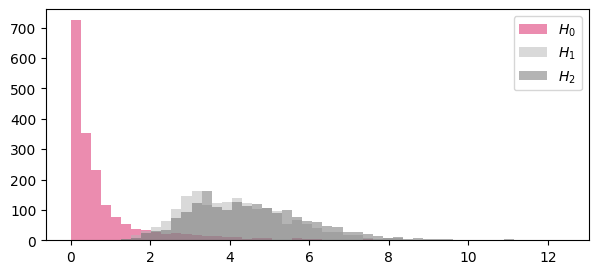

In [12]:
maxl = np.vstack(maxlife)
bins = np.linspace(0, maxl.max(), 50)

fig, ax = plt.subplots(1,1, figsize=(7,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0
for i in range(maxl.shape[1]):
    ax[j].hist(maxl[:,i], bins=bins, color=wong[i], alpha=0.5, label='$H_{{{}}}$'.format(i))
ax[j].legend();

# Loadings

In [124]:
cc = ['m', 'b', 'len', 'start', 'stop', 'contig']
ce = ['MAPE', 'MAE', 'MSE']

colnames = []
dtypes = {}

for gidx in Genes:
    for n_seg in [2,3]:
        for j in range(n_seg):
            colnames += [ '{}-L{}{}-{}'.format(transcriptomes[gidx], n_seg, j, c) for c in cc ]
            for c in ['len', 'start', 'stop']:
                dtypes['{}-L{}{}-{}'.format(transcriptomes[gidx], n_seg, j, c)] = int
            dtypes['{}-L{}{}-{}'.format(transcriptomes[gidx], n_seg, j, 'contig')] = bool
        colnames += [ '{}-L{}-{}'.format(transcriptomes[gidx], n_seg, c) for c in ce ]

colnames = np.asarray(colnames)

In [73]:
xs = np.linspace(0,1, len(peripherality))[3:]

In [210]:
reload(utils)
cidx = 2282

filename = geosrc + 'peripherality_c{:06d}.csv'.format(cidx)
peripherality = pd.read_csv(filename)
xs = np.linspace(0,1, len(peripherality))[3:]

cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, pxbar=True, PP=6)
s_ = (np.s_[cextent[2]:cextent[3]], np.s_[cextent[0]:cextent[1]])
edt = ndimage.distance_transform_edt(label[s_] == cidx)
axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, cell, label[s_], cextent, zmax, stepsize, cell_nuc)

outs = ~outside_walls.copy().reshape( list(map(len, axes))[::-1], order='F')
alpha = min([1.5*int(4e6/cell.size)/100, 0.8])

hcoords, hkde = [ [] for _ in range(2) ]

for gidx in Genes:

    coords = translocs[gidx].loc[ translocs[gidx]['cidx'] == cidx , ['X', 'Y', 'Z'] ].values.T
    
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T).evaluate(grid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(coords)))
    kde[outside_walls] = 0
    
    kde = kde/(np.sum(kde)*(stepsize**len(coords)))
    kde = kde.reshape( list(map(len, axes))[::-1], order='F')
       
    hkde.append( kde.copy() * ratios[invGenes[gidx]][invCells[cidx]] )
    hcoords.append(coords)

loc_kmax = max(map(np.max, hkde))

In [211]:
KBINS_NO = 27

kbins = np.linspace(0, np.max(edt), KBINS_NO)
cellhist = np.digitize(edt, kbins, right=True)
hsummary = [None for _ in range(len(Genes))]
hhist = [cellhist.copy() for _ in range(len(Genes))]

i = 0
for i in range(len(Genes)):
    gidx = Genes[i]
    hsummary[i] = ratios[invGenes[gidx] , invCells[cidx]] * peripherality['mean_{}_-_{}'.format(bw, transcriptomes[gidx])].values / kmax
    temp = (1e6*np.hstack(([0], hsummary[i]))).astype(int)
    with np.nditer(hhist[i], flags=['external_loop'], op_flags=['readwrite']) as it:
        for x in it:
            x[...] = temp[x]

    hsummary[i] = hsummary[i][3:]
loc_smax = 1e6*max([ max(map(np.max, hsummary[i])) for i in range(len(hsummary)) ])

# ys = ratios[invGenes[gidx] , invCells[cidx]] * peripherality['mean_{}_-_{}'.format(bw, transcriptomes[gidx])].values / kmax

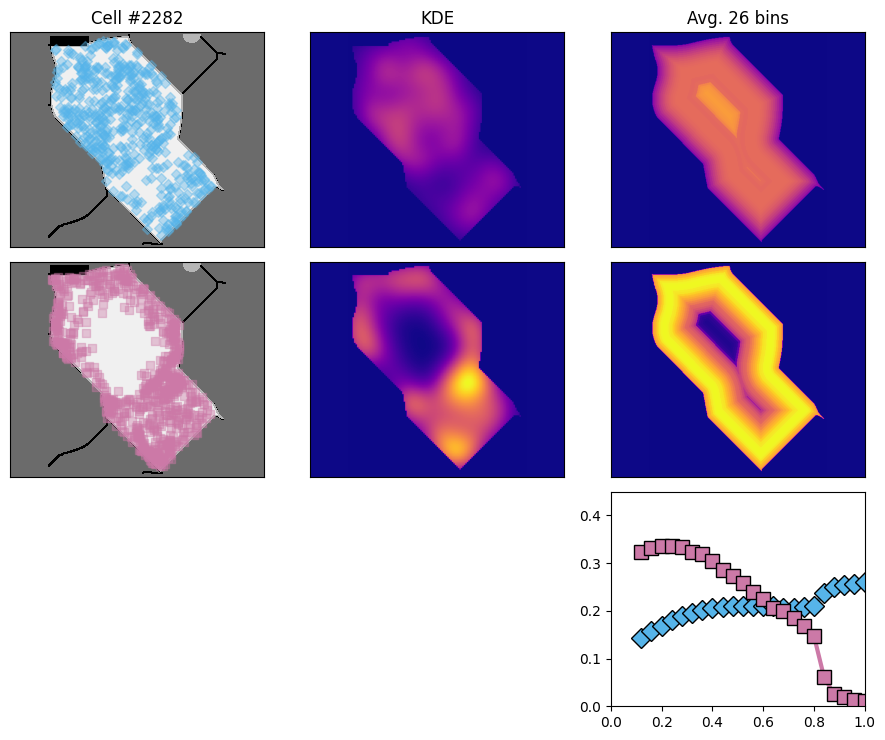

In [212]:
fig, ax = plt.subplots(3, 2+1, figsize=(6+3*1, 7.5), sharex=False, sharey=False)

for i in range(len(Genes)):
    j = 0
    ax[i,j].imshow(cell+1, cmap=cellular_cmap, origin='lower', extent=cextent, vmin=0, vmax=nnuc+2);
    ax[i,j].scatter(*(hcoords[i][:2]), color=Cs[Genes[i]], marker=Ms[Genes[i]], alpha=alpha, s=int(4e6/cell.size))
    ax[i,j].set_facecolor(wong[2])

    j += 1
    ax[i,j].imshow(np.max(hkde[i], axis=0), origin='lower', cmap=Cmap, vmin=0, vmax=loc_kmax, zorder=1)
    ax[i,j].set_facecolor( mpl.colormaps[ Cmap ](0) )

    j += 1
    ax[i, j].imshow(hhist[i], origin='lower', cmap=Cmap, vmin=0, vmax=loc_smax)
    ax[i, j].set_facecolor( mpl.colormaps[ Cmap ](0) )

ax[0,0].set_title('Cell #{}'.format(cidx), fontsize=fs)
ax[0,1].set_title('KDE', fontsize=fs)

i = 0
ax[0,2+i].set_title('Avg. {} bins'.format(KBINS_NO-1), fontsize=fs)
for j in range(len(Genes)):
    ax[2,2].plot(xs, hsummary[j], color=Cs[Genes[j]], lw=3, marker=Ms[Genes[j]], ms=10, mec='k', mew=1)
    ax[2,2].set_ylim(0, 0.45)
    ax[2,2].set_xlim(0,1)

for ix in [(2,0), (2,1)]:
    fig.delaxes(ax[ix])
    

for a in ax.ravel()[:(4 + 2*1)]:
    a.set_aspect('equal','datalim')
    a.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.tight_layout()
#plt.savefig('cell{}_periphery_analyses.png'.format(cidx), dpi=dpi, bbox_inches='tight', format='png')

#print(hsummary[0][0], '--', hsummary[1][0], sep='\n')

In [101]:
xs = np.linspace(0,1, len(peripherality))[3:]

data = np.zeros( (len(Cells), 72) )

for i in range(len(Cells)):
#for i in range(5):
    cidx = Cells[i]
    peripherality = pd.read_csv(geosrc + 'peripherality_c{:06d}.csv'.format(cidx))
    kcol = 0
    for gidx in Genes:
        
        ys = ratios[invGenes[gidx] , invCells[cidx]] * peripherality['mean_{}_-_{}'.format(bw, transcriptomes[gidx])].values / kmax
        ys = ys[3:]
        
        dys = np.gradient(ys, xs)
        
        for n_seg in [2,3]:
            #print(cidx, gidx, n_seg, sep='\t')
            rgr = tree.DecisionTreeRegressor(max_leaf_nodes=n_seg)
            rgr.fit(xs.reshape(-1, 1), dys.reshape(-1, 1))
            dys_dt = rgr.predict(xs.reshape(-1, 1)).flatten()
            
            uq, idxs, cts = np.unique(dys_dt, return_inverse=True, return_counts=True)
            css = ndimage.find_objects(idxs+1)
            
            contig = [ css[j][0].stop - css[j][0].start  == cts[j] for j in range(len(css)) ]
            
            y_pred = np.copy(ys)
            for j in range(len(css)):
                if cts[j] > 1:
                    linregress = stats.linregress(xs[css[j]], ys[css[j] ])
                    m, b = linregress.slope, linregress.intercept
                    y_pred[ css[j] ] = m*xs[ css[j] ] + b
                    data[i, kcol : kcol+6] = [m, b, cts[j], css[j][0].start, css[j][0].stop, contig[j] ]
                kcol += 6

            data[i, kcol] = metrics.mean_absolute_percentage_error(ys, y_pred); kcol += 1
            data[i, kcol] = metrics.mean_absolute_error(ys, y_pred); kcol += 1
            data[i, kcol] = metrics.mean_squared_error(ys, y_pred); kcol += 1

In [217]:
df = pd.DataFrame(data, index=Cells, columns=colnames).astype(dtypes)
for gidx in Genes:
    t = transcriptomes[gidx]
    df[t+'_L'] = np.where( (df[ t+'-L2-MAE' ] - df[ t+'-L3-MAE' ] < 0.005).values, 2, 3)
df.head()

,GLYMA_17G195900-L20-m,GLYMA_17G195900-L20-b,GLYMA_17G195900-L20-len,GLYMA_17G195900-L20-start,GLYMA_17G195900-L20-stop,GLYMA_17G195900-L20-contig,GLYMA_17G195900-L21-m,GLYMA_17G195900-L21-b,GLYMA_17G195900-L21-len,GLYMA_17G195900-L21-start,...,GLYMA_05G092200-L32-b,GLYMA_05G092200-L32-len,GLYMA_05G092200-L32-start,GLYMA_05G092200-L32-stop,GLYMA_05G092200-L32-contig,GLYMA_05G092200-L3-MAPE,GLYMA_05G092200-L3-MAE,GLYMA_05G092200-L3-MSE,GLYMA_17G195900_L,GLYMA_05G092200_L
169,0.264103,0.178267,17,6,23,True,0.526007,0.105953,6,0,...,0.014902,13,10,23,True,0.139262,0.002933,0.000016,3,2
188,0.056501,0.267864,20,3,23,True,0.401698,0.199722,3,0,...,-0.927319,5,18,23,True,0.021052,0.004292,0.000030,2,3
199,0.052889,0.182386,18,5,23,True,0.224858,0.133064,5,0,...,0.036994,12,11,23,True,0.208014,0.004666,0.000038,2,2
209,0.035310,0.290729,7,16,23,True,0.296886,0.087002,16,0,...,0.000000,0,0,0,False,0.022574,0.006074,0.000058,2,2
224,0.078804,0.340226,17,6,23,True,0.443694,0.214984,6,0,...,0.218227,3,0,3,True,0.038726,0.001903,0.000006,2,3


In [218]:
print( np.sum(df['GLYMA_17G195900_L'] == 3) , np.sum(df['GLYMA_05G092200_L'] == 3) )

64 127


In [168]:
df.sort_values(by='GLYMA_05G092200-L3-MAE', ascending=False).head(10)

,GLYMA_17G195900-L20-m,GLYMA_17G195900-L20-b,GLYMA_17G195900-L20-len,GLYMA_17G195900-L20-start,GLYMA_17G195900-L20-stop,GLYMA_17G195900-L20-contig,GLYMA_17G195900-L21-m,GLYMA_17G195900-L21-b,GLYMA_17G195900-L21-len,GLYMA_17G195900-L21-start,...,GLYMA_05G092200-L32-b,GLYMA_05G092200-L32-len,GLYMA_05G092200-L32-start,GLYMA_05G092200-L32-stop,GLYMA_05G092200-L32-contig,GLYMA_05G092200-L3-MAPE,GLYMA_05G092200-L3-MAE,GLYMA_05G092200-L3-MSE,GLYMA_17G195900_L,GLYMA_05G092200_L
1579,-0.232547,0.569152,2,21,23,True,0.174582,0.196245,21,0,...,0.000000,0,0,0,False,0.075566,0.015686,0.000427,3,2
2282,0.082723,0.164770,18,5,23,True,0.283268,0.111039,5,0,...,0.331287,6,0,6,True,0.165522,0.012663,0.000354,2,2
1207,-1.317484,1.366080,4,19,23,True,0.164677,0.171439,19,0,...,0.252809,15,0,15,True,0.069054,0.012379,0.000232,3,2
1881,0.092522,0.100583,14,0,14,True,0.281248,-0.026796,9,14,...,0.174773,3,0,3,True,0.515914,0.011754,0.000351,2,2
522,0.208147,0.198291,16,7,23,True,0.375320,0.146623,7,0,...,0.370262,11,0,11,True,0.034036,0.011742,0.000227,2,3
290,-0.139202,0.474040,13,10,23,True,0.407196,0.196779,10,0,...,-1.784747,2,19,21,True,0.043178,0.011067,0.000211,2,2
274,-0.327271,0.582681,4,19,23,True,0.153208,0.184486,19,0,...,0.000000,0,0,0,False,0.040953,0.010330,0.000148,3,2
2108,0.151384,0.187354,17,0,17,True,0.737579,-0.269066,6,17,...,0.441737,2,0,2,True,0.129135,0.009868,0.000180,3,2
669,-0.031546,0.364300,17,6,23,True,0.451036,0.193817,6,0,...,-2.180935,2,19,21,True,0.054724,0.009775,0.000164,2,2
744,0.227661,0.345447,16,7,23,True,0.613762,0.199786,7,0,...,0.355300,14,0,14,True,0.052907,0.009748,0.000150,2,3


In [215]:
cidx = 2282
peripherality = pd.read_csv(geosrc + 'peripherality_c{:06d}.csv'.format(cidx))

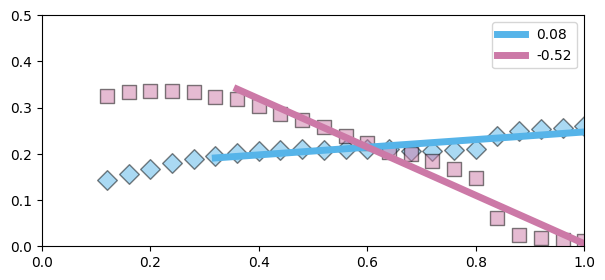

In [219]:
fig, ax = plt.subplots(1,1, figsize=(7,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

for gidx in Genes:
    t = transcriptomes[gidx]
    n_seg = df.loc[cidx, t+'_L']
    ys = ratios[invGenes[gidx] , invCells[cidx]] * peripherality['mean_{}_-_{}'.format(bw, transcriptomes[gidx])].values / kmax
    ys = ys[3:]

    ax[j].scatter(xs, ys, color=Cs[gidx], marker=Ms[gidx], edgecolor='k', s=100, zorder=1, alpha=0.5)

    k = df.loc[cidx, ['{}-L{}{}-len'.format(t, n_seg, k) for k in range(n_seg)] ].argmax()
    #for k in range(n_seg):
    m, b = df.loc[cidx, [ '{}-L{}{}-{}'.format(t, n_seg, k, c) for c in ['m','b'] ] ].values.astype(float)
    start, stop = df.loc[cidx, [ '{}-L{}{}-{}'.format(t, n_seg, k, c) for c in ['start','stop'] ] ].values.astype(int)
    stop -= 1
    ax[j].plot( [ xs[start], xs[stop] ], [m*xs[start] + b, m*xs[stop]+b], c=Cs[gidx] , zorder=2, lw=5, label='{:.2f}'.format(m))

ax[j].legend()
ax[j].set_xlim(0,1)
ax[j].set_ylim(0, 0.5);

In [220]:
c = [t+'_peripherality' for t in transcriptomes[Genes]] + [t+'_MAE' for t in transcriptomes[Genes]]
peri = pd.DataFrame(np.zeros((len(Cells), 4)), index=Cells, columns=c)


NameError: name 'peri' is not defined

array(['GLYMA_17G195900', 'GLYMA_05G092200'], dtype='<U15')

In [81]:
cidx = 188
tidx = 85
n_seg = 3

ys = ratios[invGenes[gidx] , invCells[cidx]] * peripherality['mean_{}_-_{}'.format(bw, transcriptomes[gidx])].values / kmax
ys = ys[3:]
dys = np.gradient(ys, xs)

rgr = tree.DecisionTreeRegressor(max_leaf_nodes=n_seg)
rgr.fit(xs.reshape(-1, 1), dys.reshape(-1, 1))
dys_dt = rgr.predict(xs.reshape(-1, 1)).flatten()

uq, idxs, cts = np.unique(dys_dt, return_inverse=True, return_counts=True)
css = ndimage.find_objects(idxs+1)

contig = [ css[j][0].stop - css[j][0].start  == cts[j] for j in range(len(css)) ]

y_pred = np.zeros_like(ys)
for j in range(len(css)):
    linregress = stats.linregress(xs[css[j]], ys[css[j] ])
    m, b = linregress.slope, linregress.intercept
    y_pred[ css[j] ] = m*xs[ css[j] ] + b


/home/eah4d/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/eah4d/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/eah4d/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [86]:
cts

array([20,  1,  2])

In [84]:
y_pred

array([0.24690292, 0.26603881,        nan, 0.2814246 , 0.28368462,
       0.28594464, 0.28820467, 0.29046469, 0.29272471, 0.29498473,
       0.29724475, 0.29950477, 0.30176479, 0.30402482, 0.30628484,
       0.30854486, 0.31080488, 0.3130649 , 0.31532492, 0.31758494,
       0.31984497, 0.32210499, 0.32436501])

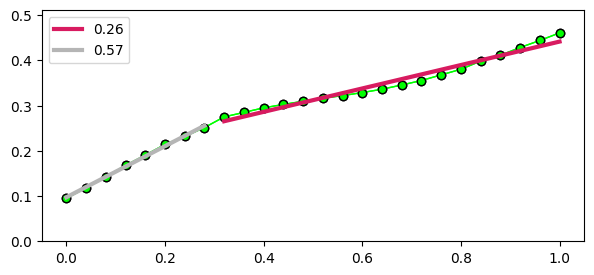

In [59]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

fig, ax = plt.subplots(1,1, figsize=(7,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ys_sl = np.ones(len(xs))
for i in range(len(uq)):

    linregress = stats.linregress(xs[css[i]], ys[css[i] ])
    ys_sl[ css[i] ] = linregress.slope*xs[css[i] ] + linregress.intercept
    
    ax[j].plot(xs, ys, lw=1, marker='o', c='lime', zorder=1, mec='k')
    
    ax[j].plot([xs[css[i]][0], xs[css[i]][-1]], [ys_sl[css[i]][0], ys_sl[css[i]][-1]], 
             color=wong[i], zorder=2, lw=3, label='{:.2f}'.format(linregress.slope))

ax[j].set_ylim(0, ys.max()+0.05)
ax[j].legend();

In [56]:
i,j = 2,0
linregress = stats.linregress(np.linspace(0,1,no_kbins[i]-1), hsummary[j][i])
print(linregress.slope, linregress.intercept, linregress.slope + linregress.intercept, sep='\t')

0.10661808529428464	0.06872860272886774	0.1753466880231524


In [40]:
4*linregress.slope + linregress.intercept

0.1584388710266073

In [37]:
16*linregress.slope + linregress.intercept

0.1753466880231524

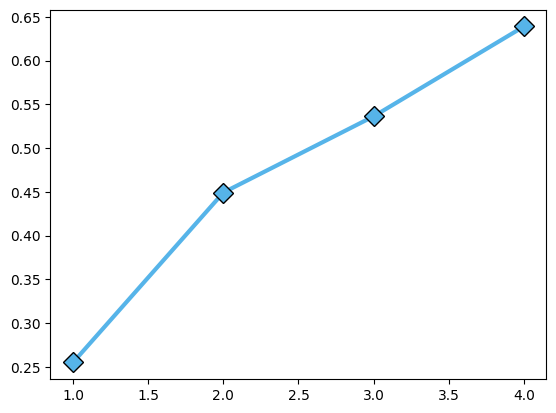

In [76]:
i = 0

plt.plot(range(1, no_kbins[i]), hsummary[0][i], color=Cs[Genes[0]], lw=3, marker=Ms[Genes[0]], ms=10, mec='k', mew=1)

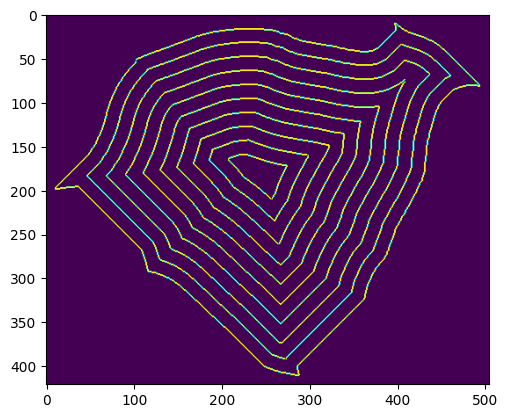

In [225]:
plt.imshow(magnitude)

In [212]:
np.unique(np.sqrt(sobel_h**2 + sobel_v**2))

array([0.        , 1.41421356, 2.        , 2.82842712, 3.16227766,
       4.        , 4.24264069, 4.47213595])

In [151]:
summary = pd.DataFrame(summary, columns=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 
                       index=range(1,len(kbins))).astype({'count':int})
summary

,count,mean,std,min,25%,50%,75%,max
1,80014,0.147944,0.070709,0.000000,0.096191,0.141035,0.193935,0.351713
2,67034,0.128926,0.067674,0.014951,0.076832,0.113943,0.168425,0.346143
3,51150,0.046118,0.031719,0.002603,0.023212,0.038568,0.060578,0.263788
4,37664,0.010719,0.007858,0.000277,0.004978,0.008590,0.014400,0.056187
5,24288,0.007620,0.005340,0.000000,0.003390,0.006875,0.011083,0.023632
6,10010,0.007095,0.006506,0.000000,0.000000,0.005968,0.011778,0.024121


In [119]:
pd.Series(hkde[:,  zoom == hlevel ].ravel()).describe().index

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')